# Preliminary results of Experiment 14

These are obtained from a subset of the first runs, and from the labview tracking files

In [1]:
import os
import sys
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.spatial as spa
import scipy.optimize as spo
import trackpy as tp
import pims 

import support as sp

from pims import pipeline
@pipeline
def as_gray(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

from IPython.display import HTML

from tqdm import tqdm_notebook

%matplotlib inline

idx = pd.IndexSlice

%load_ext autoreload
%autoreload 2

In [2]:
directory = "D:/"

In [3]:
video_list = sp.get_names(os.path.join(directory,"Experiment14"),ext = ".avi")

video_list = video_list[:]

omit = ["Depinning_2019_01_25_10_45_11","Depinning_2019_01_25_11_01_33"]

video_list = [name for name in video_list if 
     all([os.path.split(name)[-1]!=item for item in omit])]

In [4]:
name = video_list[0]

In [5]:
field_filename = os.path.join(os.path.join(directory,"Experiment14"),"Field-2019-01-23.dat")

field= pd.read_csv(field_filename,delim_whitespace=True)
field["time"] = pd.to_datetime(field["Time(s)"]+2*3600, unit="s", origin=pd.Timestamp('1904-01-01'))
field = field.set_index("time").filter(["X_Amplitude"])

In [6]:
def load_preprocess(name):
    trj = sp.load_dat(name)
    trj = sp.from_px_to_um(trj,0.1805)
    trj = sp.add_layers(trj)
    trj = sp.recenter(trj)
    trj = sp.field_values(trj,field)
    trj = sp.calculate_polar(trj)
    trj = sp.calculate_velocities(trj)
    trj = sp.assign_direction(trj)
    return trj

In [7]:
trj = load_preprocess(name)

D:\Dropbox\Colloids\Microrheometer\Depinning\support.py:199: RuntimeWarning: invalid value encountered in sign
  time_direction = np.sign(time_direction)


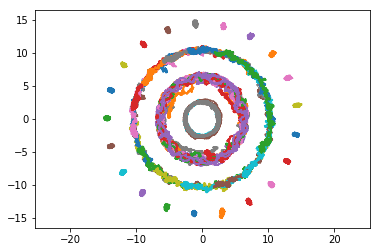

In [8]:
sp.draw_trj(trj)

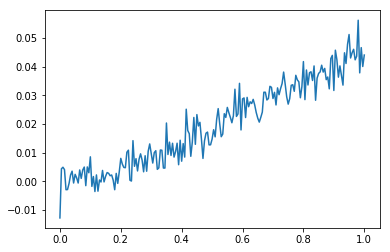

In [9]:
trj["torque"] = (1.5*trj.field)**2
plt.plot(-trj.groupby("torque").mean().omega)

In [10]:
import warnings; 
warnings.simplefilter('ignore')
trj = pd.concat([load_preprocess(name) for name in tqdm_notebook(video_list)])

A Jupyter Widget

In [11]:
trj.head()

x  \
name                          time                          id             
Depinning_2019_01_25_10_31_31 2019-01-25 11:31:31.704999924 0  -1.411339   
                                                            1   3.165419   
                                                            2  -5.481434   
                                                            3   6.962597   
                                                            4  -9.033674   

                                                                        y  \
name                          time                          id              
Depinning_2019_01_25_10_31_31 2019-01-25 11:31:31.704999924 0  -14.400906   
                                                            1  -13.581436   
                                                            2  -13.317004   
                                                            3  -12.243570   
                                                            4  -11.129344   

                                                                layer  field  \
name                          time                          id                 
Depinning_2019_01_25_10_31_31 2019-01-25 11:31:31.704999924 0     0.0    0.0   
                                                            1     0.0    0.0   
                                                            2     0.0    0.0   
                                                            3     0.0    0.0   
                                                            4     0.0    0.0   

                                                                        r  \
name                          time                          id              
Depinning_2019_01_25_10_31_31 2019-01-25 11:31:31.704999924 0   14.469899   
                                                            1   13.945440   
                                                            2   14.400997   
                                                            3   14.084842   
                                                            4   14.334209   

                                                                   theta  \
name                          time                          id             
Depinning_2019_01_25_10_31_31 2019-01-25 11:31:31.704999924 0  -1.668488   
                                                            1  -1.341815   
                                                            2  -1.961272   
                                                            3  -1.053729   
                                                            4  -2.252630   

                                                                rel_time  vx  \
name                          time                          id                 
Depinning_2019_01_25_10_31_31 2019-01-25 11:31:31.704999924 0        0.0 NaN   
                                                            1        0.0 NaN   
                                                            2        0.0 NaN   
                                                            3        0.0 NaN   
                                                            4        0.0 NaN   

                                                                vy  vr  vth  \
name                          time                          id                
Depinning_2019_01_25_10_31_31 2019-01-25 11:31:31.704999924 0  NaN NaN  NaN   
                                                            1  NaN NaN  NaN   
                                                            2  NaN NaN  NaN   
                                                            3  NaN NaN  NaN   
                                                            4  NaN NaN  NaN   

                                                                omega  \
name                          time                          id          
Depinning_2019_01_25_10_31_31 2019-01-25 11:31:31.704999924 0     NaN   
                              

In [12]:
trj.direction.unique()

array([nan, 'fwd', 'bwd'], dtype=object)

In [13]:
def outer_radius(series):
    return series[series.layer == 0].r.mean()

In [14]:
catalogue = trj.groupby("name").apply(outer_radius)
catalogue = pd.DataFrame(catalogue,columns=["r"])

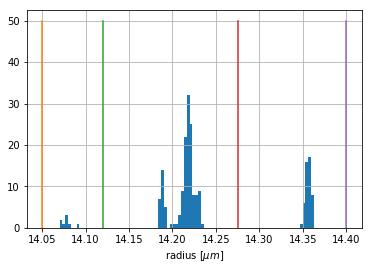

In [15]:
r_lim = np.array([14.05,14.12,14.275,14.4])
catalogue.r.hist(bins = 90)
plt.plot([r_lim,r_lim],[np.zeros(len(r_lim)),50*np.ones(len(r_lim))]);
plt.xlabel(r"radius [$\mu{}m$]")

In [16]:
C = pd.cut(catalogue.r, bins = r_lim, labels = [3.38,3.45,3.5])

catalogue["r_nom"] = C.cat.categories[C.cat.codes]

In [17]:
catalogue.head()

,r,r_nom
name,,
Depinning_2019_01_25_10_31_31,14.354456,3.5
Depinning_2019_01_25_10_38_21,14.356118,3.5
Depinning_2019_01_25_10_54_43,14.354339,3.5
Depinning_2019_01_25_11_08_23,14.357685,3.5
Depinning_2019_01_25_11_15_13,14.358796,3.5


In [18]:
trj["torque"] = (1.5*trj.field)**2

In [19]:
omega = pd.DataFrame(trj.groupby(["name","direction","torque","layer"]).mean().omega)

In [20]:
omega.head()

omega
name                          direction torque layer          
Depinning_2019_01_25_10_31_31 bwd       0.005  0.0    0.001489
                                               1.0    0.003994
                                               2.0   -0.019282
                                               3.0   -0.003345
                                        0.010  0.0   -0.001642

In [21]:
name = omega.loc[idx[:,:,:,4],:].index.get_level_values("name").unique()

omega = omega.drop(omega.loc[idx[name,:,:,:],:].index)

In [22]:
catalogue = catalogue[catalogue.r_nom>3.38]

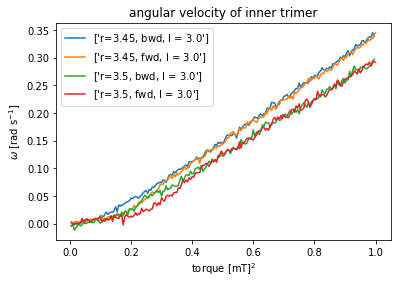

In [23]:
fig, ax = plt.subplots(1,1)
for r,cat in catalogue.groupby("r_nom"):
    if r>3.38:
        for a,om in omega.loc[idx[cat.index,:,:,3],:].groupby(["direction","layer"]):
            label = [r"r=$%s$, %s, l = $%s$"%(r,a[0],a[1])]
            om = om.groupby("torque").mean()
            ax.plot(om.index,-om.omega,label=label)
        
ax.legend()
ax.set_title(r"angular velocity of inner trimer")
ax.set_xlabel(r"torque [mT]$^2$")
ax.set_ylabel(r"$\omega$ [rad s$^{-1}$]")

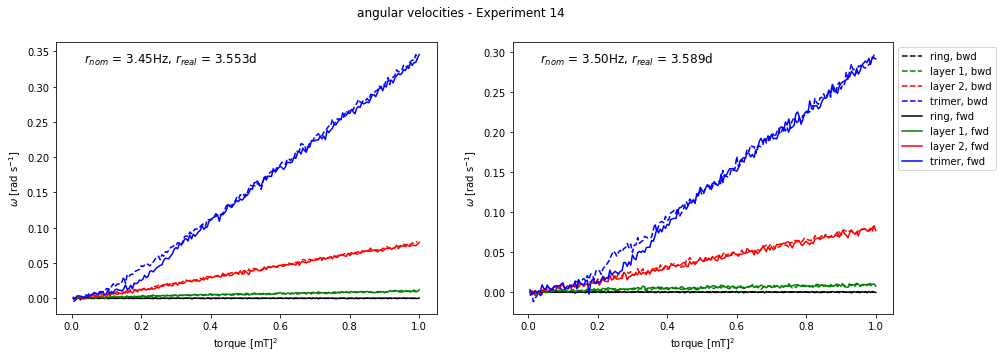

In [24]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

for i,(r,cat) in enumerate(catalogue.groupby("r_nom")):
    ax[i].set_prop_cycle(color=['black', 'green', 'red','blue'])
    
    r_real = cat.r.mean()/4
    
    for a,om in omega.loc[idx[cat.index,:,:,:],:].groupby(["direction","layer"]):
        
        if a[1] == 0:
            label = "ring, %s"%(a[0])
        elif a[1] == 3:
            label = "trimer, %s"%(a[0])
        else:
            label = "layer %u, %s"%(a[1],a[0])
       
        #label = [r"r=$%s$, %s, l = $%s$"%(r,a[0],a[1])]
        om = om.groupby("torque").mean()
        linestyle = '-'
        if (a[0]=='bwd'):
            linestyle = "--"

        ax[i].set_title("$r_{nom}$ = %2.2fHz, $r_{real}$ = %2.3fd"%(r,r_real),position=(0.3, 0.9))

        ax[i].plot(om.index,-om.omega,linestyle,label=label)
        ax[i].set_xlabel(r"torque [mT]$^2$")
        ax[i].set_ylabel(r"$\omega$ [rad s$^{-1}$]")

fig.suptitle('angular velocities - Experiment 14')
ax[1].legend(bbox_to_anchor=(1, 1))

# Structure of the Microrheometer Layers

In [25]:
videos = [
    "Depinning_2019_01_25_10_31_31",
    "Depinning_2019_01_26_09_18_50",
    "Depinning_2019_01_28_12_58_51"]

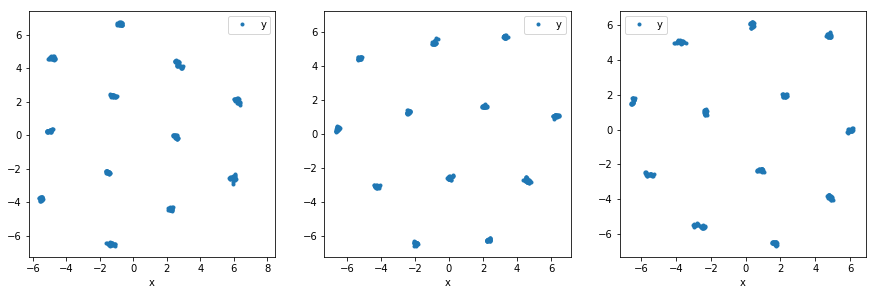

In [26]:
fig, ax = plt.subplots(1,3,figsize=(15,8))

for i,v in enumerate(videos):
    time = trj.loc[idx[v,:,:],:].index.get_level_values("time").unique()
    
    trj.loc[idx[v,time[0:30],:],["x","y"]][
        (trj.loc[idx[v,:,:],"layer"].isin([2,3]))].plot(ax = ax[i],x = "x", y = "y",marker='.',linestyle='')
    ax[i].set_aspect("equal")
    ax[i].axis("square")

In [27]:
def animate_video(v, frames=30, interval=33,dec = 1):
    video = pims.Video(os.path.join("D:\Experiment14",v+".avi"))
    w = 3.5
    fig, ax = plt.subplots(1,1,figsize=(w,w))
    ax.tick_params(which='both',labelleft = False,labelbottom = False)

    def animate(i):
        ax.axis('off')
        ax.imshow(video[dec*i])
        ax.tick_params(which='both',labelleft = False, labelbottom = False)
        #fig.tight_layout()
        ax.set_title(r""+v)
        ax.set_xlim(np.array([200,500])-20)
        ax.set_ylim(np.array([200,500])-130)
        return ax
    anim = animation.FuncAnimation(fig, animate, frames=frames, interval=interval, blit=False)
    plt.close(anim._fig)
    
    return anim

In [28]:
anim = [animate_video(videos[0],frames = 30, interval = 33),
        animate_video(videos[1],frames = 30, interval = 33),
        animate_video(videos[2],frames = 30, interval = 33)]

In [29]:
HTML("""<div class="row">
  <div class="col-sm-3">%s</div>
  <div class="col-sm-3">%s</div>
  <div class="col-sm-3">%s</div></div>"""%(anim[0].to_html5_video(),anim[1].to_html5_video(),anim[2].to_html5_video()))

In [30]:
anim = [animate_video(videos[0],frames = 200, interval = 33,dec = 30),
        animate_video(videos[1],frames = 200, interval = 33,dec = 30),
        animate_video(videos[2],frames = 200, interval = 33,dec = 30)]

HTML("""<div class="row">
  <div class="col-sm-3">%s</div>
  <div class="col-sm-3">%s</div>
  <div class="col-sm-3">%s</div></div>"""%(anim[0].to_html5_video(),anim[1].to_html5_video(),anim[2].to_html5_video()))